# Problem Statement

- Amazon is an online shopping website that now caters to millions of people everywhere. Over 4,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
- The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
- You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [1]:
import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
import re,string
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')



In [2]:
#load train dataset and check first 5 records

train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
train_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


#### Check info of the data

In [3]:
#shape 
train_df.shape,test_df.shape

((4000, 8), (1000, 8))

#### training dataset contains 4k rows and 8 features

In [4]:
# info
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


In [5]:
#### train dataset contains total 4k records with 8 features, all are ojects type

In [6]:
#describe
train_df.describe().transpose()

,count,unique,top,freq
name,4000,23,Amazon Echo Show Alexa-enabled Bluetooth Speak...,676
brand,4000,1,Amazon,4000
categories,4000,23,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",628
primaryCategories,4000,4,Electronics,2600
reviews.date,4000,638,2017-01-23T00:00:00.000Z,99
reviews.text,4000,3598,Got this for my Daughter-in-Law and she loves ...,4
reviews.title,3990,2606,Great tablet,100
sentiment,4000,3,Positive,3749


#### Observations from the above train data 
- Dataset contains total 4 primary categories.
- Electronics category is the most used one with 2600 records
- Total subcategories are 23, brand is only one i.e. Amazon. 
- Total 3 types of sentiments are there Positive,Neagtive and Neutral, most of the sentiments looks Positive i.e. 3749 positive records are there.

In [7]:
#### Analyzing more with data i.e categories,review dates 

In [8]:
train_df.groupby('primaryCategories').nunique()

,name,brand,categories,reviews.date,reviews.text,reviews.title,sentiment
primaryCategories,,,,,,,
Electronics,18,1,17,458,2310,1706,3
"Electronics,Hardware",2,1,3,203,1095,827,3
"Electronics,Media",1,1,1,16,17,17,1
"Office Supplies,Electronics",2,1,2,140,204,181,3


In [9]:
train_df.groupby('reviews.date')['reviews.date'].count().sort_values(ascending=False)

reviews.date
2017-01-23T00:00:00.000Z    99
2017-01-18T00:00:00.000Z    88
2017-01-06T00:00:00.000Z    87
2017-12-01T00:00:00.000Z    73
2017-01-16T00:00:00.000Z    69
                            ..
2016-10-25T00:00:00.000Z     1
2017-11-19T07:47:58.000Z     1
2016-10-18T00:00:00.000Z     1
2016-10-10T00:00:00.000Z     1
2018-09-15T15:58:24.000Z     1
Name: reviews.date, Length: 638, dtype: int64

In [10]:
train_df['reviews.date'] = pd.to_datetime(train_df['reviews.date'])

In [11]:
#### Lets check the reviews duration, first date of review and lastdate of reviews

In [12]:
df2 = train_df.agg(Review_Start_Date=('reviews.date', np.min), Review_End_Date=('reviews.date', np.max))
df2

,reviews.date
Review_Start_Date,2014-10-24 00:00:00+00:00
Review_End_Date,2018-09-15 15:58:24+00:00


In [13]:
#### Finding the review data available for how many days

In [14]:
df2["reviews.date"].diff().apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype(int)

Review_Start_Date       0
Review_End_Date      1422
Name: reviews.date, dtype: int32

#### 1422 days data is available for analysis

In [15]:
#### Check for minimum and maximum length for review text

long_review_length = train_df["reviews.text"].map(len).max()
short_review_length = train_df["reviews.text"].map(len).min()

long_review_length,short_review_length

(8351, 45)

#### Longest review is 8351 characters and shortest review length is 45 characters long 

In [16]:
# Check the maximum and minimum review text 

review_length = train_df['reviews.text'].astype(str).map(len)
print('largest comment = \n'+train_df.loc[review_length.argmax(), 'reviews.text'])
print ('\n shortest comment = \n'+train_df.loc[review_length.argmin(), 'reviews.text'])

largest comment = 
I've had lots of tablets in the past, mostly from the Samsung line, but this is my first Amazon Fire, so I want to write this review for others who have never tried one of these. At the time that this was written, Alexa had not been added to the tablet.First, while this device runs an Android type of operating system, Amazon puts its own spin on the operating system. I don't feel like I'm using Android. This feels different to me. It doesn't have the same level of customization that Android users have come to appreciate. That being said, if you are an Amazon Prime member, this device has been tailored to be your content entertainment machine. It's simply a fun way to consume your magazines, books, etc.There are 3 on-screen buttons on the bottom of the device. The middle button immediately takes you to your home screen. The button to the left acts as a sort of "back" button. It also lets me get rid of my keyboard when I don't need it on screen, but it's open. The butt

In [17]:
# First 5 largest reviews
large_texts = train_df['reviews.text'].map(len).nlargest(n=5)
train_df.loc[large_texts.index,'reviews.text']


1013    I've had lots of tablets in the past, mostly f...
306     Even when I‚Äôm outside in bright sunlight, th...
2088    Even when I‚Äôm outside in bright sunlight, th...
3767    When I first read about Amazon Echo Show, I th...
3295    When they first announced the Kindle Oasis, I ...
Name: reviews.text, dtype: object

In [18]:
train_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17 00:00:00+00:00,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04 00:00:00+00:00,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [19]:
#### Largest review data contain a lot of comments which may not be much helpful for prediction, 
# so we will use reviews of maximum length up to 500 characters.

In [20]:
train_df = train_df[train_df['reviews.text'].map(len)<500]
train_df

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26 00:00:00+00:00,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20 00:00:00+00:00,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04 00:00:00+00:00,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23 00:00:00+00:00,This is a great product. Light weight. I wish ...,You will love it,Positive
...,...,...,...,...,...,...,...,...
3994,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-27 00:00:00+00:00,"It is great , I like it very much. I can find ...",great responding,Positive
3995,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-08 00:00:00+00:00,"It‚Äôs fun for the family to play with, but it...",Fun toy,Positive
3996,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,2017-03-31 00:00:00+00:00,"I love the Kindle, it is a great product. It r...",Great Product,Positive
3998,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27 00:00:00+00:00,This is the second Amazon Fire 7 tablet I have...,A great 7 inch tablet at a great price,Positive


#### Check for missing values


In [21]:
train_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        8
sentiment            0
dtype: int64

#### reviews.title contains 8 missing values, but we can ignore it for now, as our main focus is on review text.

#### Check for duplicate values

In [22]:
train_df.duplicated().sum()

58

#### total 58 records are duplicated. we need to analyze more for duplicate data

In [23]:
train_df[train_df.duplicated()]

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
709,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23 00:00:00+00:00,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
866,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2017-09-01 00:00:00+00:00,"This is really good if you read a lot, doesn't...",Great buy if you read a lot,Positive
1085,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-02-15 00:00:00+00:00,Great for kids. Simple and inexpensive. 16G mu...,Simple tablet,Positive
1116,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-24 00:00:00+00:00,Item work well and was easy to read from in da...,Work,Positive
1131,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-05-27 00:00:00+00:00,"Good tablet for my daughter! She loves it ,but...",Great!,Positive
1181,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-10-28 00:00:00+00:00,Gave as a gift to niece in hospital she loved ...,Great Tablet,Positive
1216,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-12-07 00:00:00+00:00,Tablets are best used for personal reading. Cl...,Its a gift,Positive
1328,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2017-12-08 00:00:00+00:00,I purchased this Kindle for my daughter and sh...,Nice Kindle!,Positive
1365,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2017-01-06 00:00:00+00:00,I love my kindle it makes it so much easier to...,Love the product,Positive
1611,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-09-09 00:00:00+00:00,Quite an upgrade from the original Fire. The d...,Love this Fire!,Positive


In [24]:
#Check one duplicate entry

train_df[train_df['reviews.title']=='A good upgrade']

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
509,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2017-12-09 00:00:00+00:00,I had the 4th generation. I am quite happy wit...,A good upgrade,Positive
3497,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2017-12-09 00:00:00+00:00,I had the 4th generation. I am quite happy wit...,A good upgrade,Positive


#### We can remove duplicate entries as we need to use unique records for better analysis

In [25]:
duplicated_data = train_df.duplicated(keep='first')
df_new = train_df[~duplicated_data] 
df_new.shape

(3817, 8)

#### 58 records are removed

In [26]:
# check if duplicate records are removed.
df_new.duplicated().sum()

0

#### Check the distribution of sentiment data

In [27]:
df_new.sentiment.value_counts()

Positive    3594
Neutral      149
Negative      74
Name: sentiment, dtype: int64

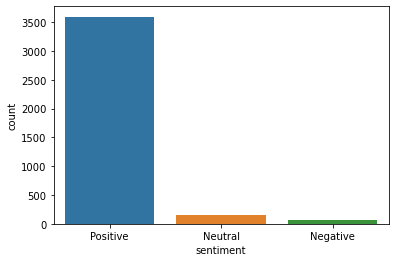

In [28]:
sns.countplot(df_new['sentiment'])
plt.show()

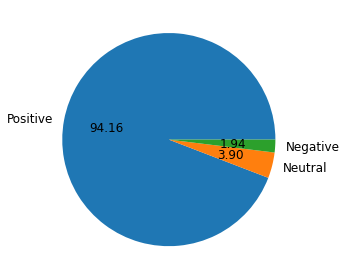

In [29]:
# Check the percentage of each sentiment type

df_new.sentiment.value_counts().plot(kind='pie',autopct='%.2f',textprops={'fontsize': 12},label='')
plt.tight_layout()
plt.show()

#### More than 94 percent data is for positive sentiment. 3.93 percent is Neutral and 1.91 percent Negative sentiments. The data is higly imbalanced. Will review later on imbalance data 

#### Review cateogrywise sentiments  

In [30]:
df_cat_sentiment = df_new.groupby(['primaryCategories','sentiment'])['brand'].count()
df_cat_sentiment

primaryCategories            sentiment
Electronics                  Negative       56
                             Neutral       110
                             Positive     2319
Electronics,Hardware         Negative       16
                             Neutral        28
                             Positive     1079
Electronics,Media            Positive       13
Office Supplies,Electronics  Negative        2
                             Neutral        11
                             Positive      183
Name: brand, dtype: int64

In [31]:
category_senti_count = df_new.groupby(['primaryCategories','sentiment'])['brand'].count().reset_index()
category_senti_count['Percentage'] = 100 * category_senti_count['brand']  / category_senti_count['brand'].sum()
category_senti_count

,primaryCategories,sentiment,brand,Percentage
0,Electronics,Negative,56,1.467121
1,Electronics,Neutral,110,2.881844
2,Electronics,Positive,2319,60.754519
3,"Electronics,Hardware",Negative,16,0.419177
4,"Electronics,Hardware",Neutral,28,0.733560
5,"Electronics,Hardware",Positive,1079,28.268274
6,"Electronics,Media",Positive,13,0.340582
7,"Office Supplies,Electronics",Negative,2,0.052397
8,"Office Supplies,Electronics",Neutral,11,0.288184
9,"Office Supplies,Electronics",Positive,183,4.794341



a1a#### df_cat_sentiment.unstack().plot(kind='barh',stacked=True)

#### Doing the product wise review analysis

In [32]:
df_new.groupby(['name'])['brand'].count().sort_values(ascending=False)

name
Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                                                     649
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                            619
Amazon - Echo Plus w/ Built-In Hub - Silver                                                                                         474
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                              436
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue                                                             335
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                               287
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                             170
Amazon Tap - Alexa-Enabled Portable Bluetoo

- highest review recevied for  Aleax enabled 7" screen bluetooth speaker 
- lowest reviewed received for Fire TV with 4k Ultra HD

In [33]:
# Brand is only one so we can remove it. date is not useful for review analysis so we can dropped that also.
# title is also not helpful as same type of data is available in text feature.

In [34]:
df_new = df_new.drop(['brand','reviews.date','reviews.title'],axis=1)

In [35]:
df_new

,name,categories,primaryCategories,reviews.text,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Purchased on Black FridayPros - Great Price (e...,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",Just an average Alexa option. Does show a few ...,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...","eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics","very good product. Exactly what I wanted, and ...",Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...","Computers/Tablets & Networking,Tablets & eBook...",Electronics,This is the 3rd one I've purchased. I've bough...,Positive
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...","Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",This is a great product. Light weight. I wish ...,Positive
...,...,...,...,...,...
3994,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,"It is great , I like it very much. I can find ...",Positive
3995,Amazon - Echo Plus w/ Built-In Hub - Silver,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware","It‚Äôs fun for the family to play with, but it...",Positive
3996,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...","Computers,Electronics Features,Tablets,Electro...",Electronics,"I love the Kindle, it is a great product. It r...",Positive
3998,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...","Computers/Tablets & Networking,Tablets & eBook...",Electronics,This is the second Amazon Fire 7 tablet I have...,Positive


In [36]:
#df_new.rename(columns = {'newsentiment':'sentiment'}, inplace = True)

In [37]:
y = df_new['sentiment']
X = df_new['reviews.text']


In [38]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.20,random_state=42)
X_train.shape,X_val.shape

((3053,), (764,))

In [39]:
def preprocess_text(text,tokenizer=None):
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    text = text.replace(".",", ").replace(". ", ", ")
    text = re.sub(r'[()]', " ", text)
    text = re.sub(r"\d+"," ",text)
    text = text.translate(str.maketrans('','',string.punctuation))

   # new_stopwords = ["when", "that", "while", "from", "which", "also", "without", "will", "just", "after",
   #                  "amazon","one","two","high","got","purchased","pros","cons","ive"]

    #stop_words = nltk.corpus.stopwords.words('english')
    #stop_words.extend(new_stopwords)

    tokens = word_tokenize(text)  # Get tokens from text
    #tokens = [lemmatizer.lemmatize(t) for t in tokens if not t in stop_words]  # Remove stopwords

    tokens = [t for t in tokens if len(t) > 2]  # Remove short tokens
    
    if tokenizer is not None:
        return tokens
    else:
        clean_tokens = []
        for tok in tokens:
            tok = tok.strip() # remove space
            clean_tokens.append(tok)
        return " ".join(clean_tokens)


In [40]:
X_train = X_train.apply(lambda x: preprocess_text(x,))
X_train_clean = X_train

y_train_clean = y_train
X_train.head()

727        great product for quickly charging your kindle
2129    echo plus seems work they say have running two...
667     son loves easy use and download books requeste...
3361    has great camera and really enjoy games and fa...
3545    this actually pretty good little tablet not th...
Name: reviews.text, dtype: object

In [41]:
#### for another approach
'''
X_train1 = df_new['reviews.text']
X_train1 = X_train1.apply(lambda x: preprocess_text(x,))
X_train_clean1 = X_train1

y_train1 = df_new['sentiment']
y_train_clean1 = y_train1
'''

X_test = test_df['reviews.text']
y_test = test_df['sentiment']


In [42]:
X_test[:1]

0    Amazon kindle fire has a lot of free app and c...
Name: reviews.text, dtype: object

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 

In [44]:
MNB_model = Pipeline([("vect", CountVectorizer(stop_words= "english")), 
                            ("tfidf", TfidfTransformer()), 
                            ("clf_multinomialnb", MultinomialNB())])


In [45]:
MNB_model.fit(X_train,y_train)
predictedMultiNB = MNB_model.predict(X_val)

In [46]:
confusion_matrix(predictedMultiNB,y_val)

array([[  0,   0,   0],
       [  0,   0,   0],
       [ 16,  30, 718]], dtype=int64)

In [47]:
print(classification_report(y_val, predictedMultiNB))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        16
     Neutral       0.00      0.00      0.00        30
    Positive       0.94      1.00      0.97       718

    accuracy                           0.94       764
   macro avg       0.31      0.33      0.32       764
weighted avg       0.88      0.94      0.91       764



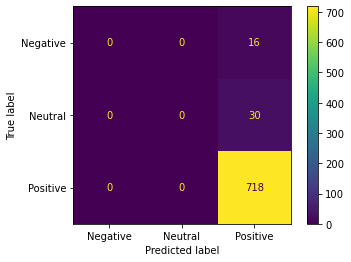

In [48]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(MNB_model,X_val,y_val)
plt.show()

#### validate if every review is 'Positive'

In [49]:
newtext = ['bad product']
predict_text = MNB_model.predict(newtext)
predict_text[0]

'Positive'

In [50]:
y_train.value_counts()

Positive    2876
Neutral      119
Negative      58
Name: sentiment, dtype: int64

#### We can check most frequent  words using Wordcount

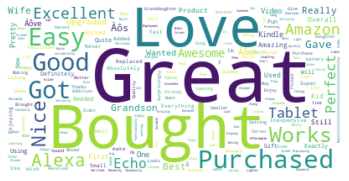

In [51]:
Positive_data = df_new.loc[df_new['sentiment']=='Positive', 'reviews.text']
words = " ".join(Data.split()[0] for Data in Positive_data)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

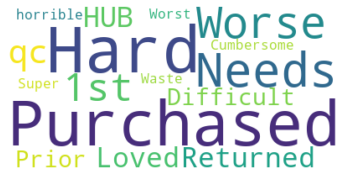

In [52]:
Negative_data = df_new.loc[df_new['sentiment']=='Negative', 'reviews.text']
words = " ".join(Data.split()[0] for Data in Negative_data)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Dataset is imbalanced because of that every predicted review is 'Positive'. 
#### We need to balanced data to get the correct predicted result

#### review data is text data, so first we need to convert text data to vector data 

In [53]:
#Resampling minority class using SMOTE

In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
# Now again we can test with MultinomialNB

In [56]:

def get_reports(models,xtrain,ytrain,xtest,ytest):
    for model in models:
        model.fit(xtrain,ytrain)
        y_pred = model.predict(xtest)
        print(classification_report(ytest, y_pred))
        

In [57]:
X_train.head()

727        great product for quickly charging your kindle
2129    echo plus seems work they say have running two...
667     son loves easy use and download books requeste...
3361    has great camera and really enjoy games and fa...
3545    this actually pretty good little tablet not th...
Name: reviews.text, dtype: object

In [58]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

MNB = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), MultinomialNB())
RF = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), RandomForestClassifier())
XGB = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), XGBClassifier())
DT = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), DecisionTreeClassifier())
SVM_linear = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), LinearSVC())
SVM_rbf = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), svm.SVC(kernel='rbf', gamma=0.5, C=0.1))
SVM_poly = make_pipeline_imb(TfidfVectorizer(), RandomOverSampler(), svm.SVC(kernel='poly', degree=3, C=1))

models = {'mnb':MNB,'rf':RF,'xgb':XGB,'dt':DT,'svm_linear':SVM_linear,'svm_rbf':SVM_rbf,'svm_poly':SVM_poly}
#models = [MNB_model,RF_model]

for i in models:
    print('---------',i)
    models[i].fit(X_train,y_train)
    y_pred = models[i].predict(X_val)
    print(classification_report(y_val, y_pred))
    f1score = f1_score(y_val,y_pred,average='macro')
    print("f1_score:",f1score)
    print("-------------------------------------------")




--------- mnb
              precision    recall  f1-score   support

    Negative       0.31      0.31      0.31        16
     Neutral       0.25      0.50      0.34        30
    Positive       0.97      0.93      0.95       718

    accuracy                           0.90       764
   macro avg       0.51      0.58      0.53       764
weighted avg       0.93      0.90      0.91       764

f1_score: 0.5339865346887819
-------------------------------------------
--------- rf
              precision    recall  f1-score   support

    Negative       1.00      0.25      0.40        16
     Neutral       1.00      0.17      0.29        30
    Positive       0.95      1.00      0.97       718

    accuracy                           0.95       764
   macro avg       0.98      0.47      0.55       764
weighted avg       0.95      0.95      0.94       764

f1_score: 0.5535318268515824
-------------------------------------------
--------- xgb
[23:57:35] WARNING: C:/Users/Administrator/workspac

--------- mnb


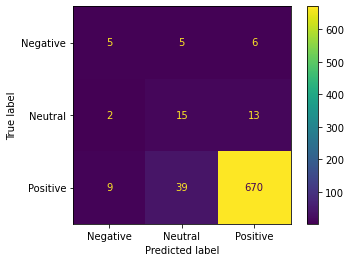

--------- rf


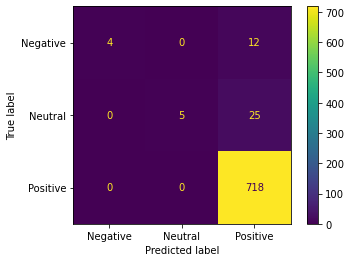

--------- xgb


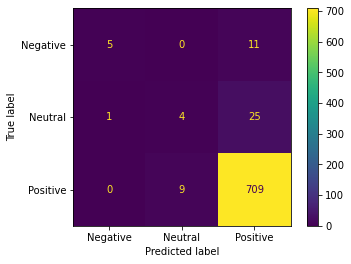

--------- dt


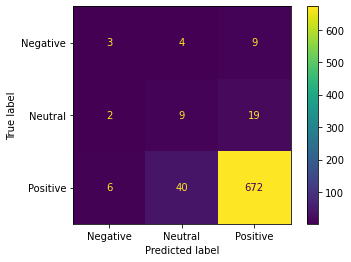

--------- svm_linear


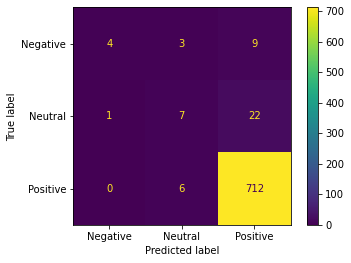

--------- svm_rbf


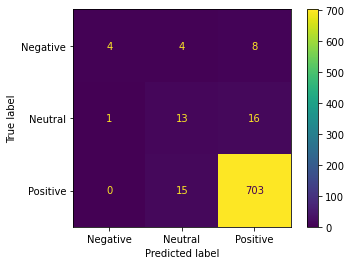

--------- svm_poly


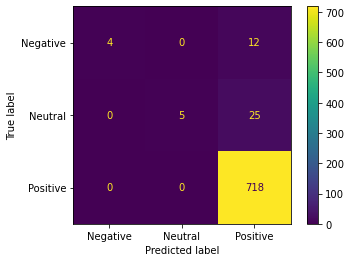

In [59]:
for i in models:
    print('---------',i)
    #models[i].fit(X_train,y_train)
    y_pred = models[i].predict(X_val)
    plot_confusion_matrix(models[i],X_val,y_val)
    plt.show()

In [60]:
for i in models:
    print('---------',i)
    models[i].fit(X_train,y_train)
    y_pred1 = models[i].predict(X_test)
    print(classification_report(y_test, y_pred1))
    f1score = f1_score(y_test,y_pred1,average='macro')
    print("f1_score:",f1score)
    print("-------------------------------------------")

--------- mnb
              precision    recall  f1-score   support

    Negative       0.19      0.17      0.18        24
     Neutral       0.20      0.46      0.28        39
    Positive       0.97      0.92      0.94       937

    accuracy                           0.88      1000
   macro avg       0.45      0.52      0.47      1000
weighted avg       0.92      0.88      0.90      1000

f1_score: 0.4662657206226834
-------------------------------------------
--------- rf
              precision    recall  f1-score   support

    Negative       1.00      0.17      0.29        24
     Neutral       1.00      0.21      0.34        39
    Positive       0.95      1.00      0.97       937

    accuracy                           0.95      1000
   macro avg       0.98      0.46      0.53      1000
weighted avg       0.95      0.95      0.93      1000

f1_score: 0.5332154370452242
-------------------------------------------
--------- xgb
[23:58:40] WARNING: C:/Users/Administrator/workspac

--------- mnb


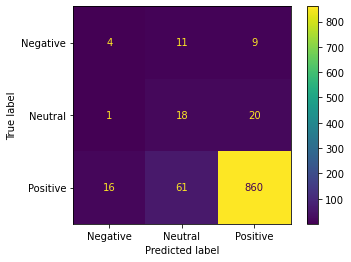

--------- rf


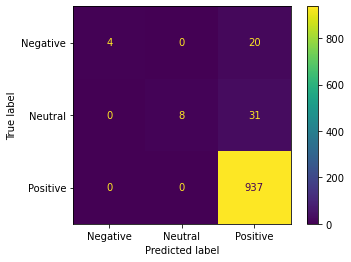

--------- xgb


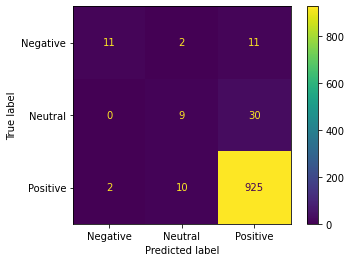

--------- dt


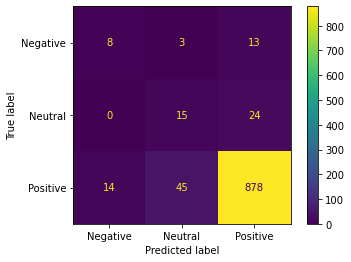

--------- svm_linear


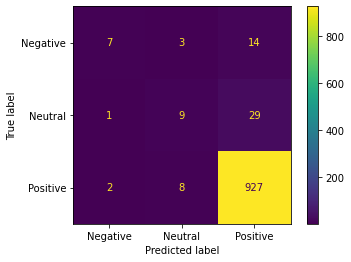

--------- svm_rbf


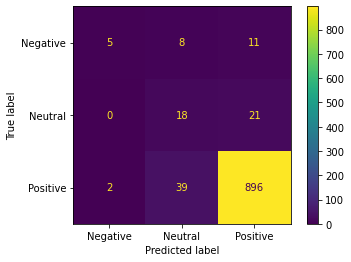

--------- svm_poly


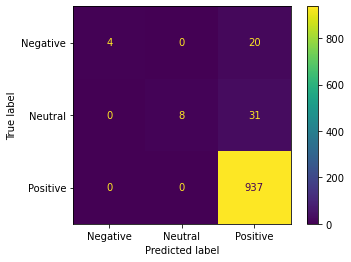

In [61]:
for i in models:
    print('---------',i)
    #models[i].fit(X_train,y_train)
    y_pred = models[i].predict(X_test)
    plot_confusion_matrix(models[i],X_test,y_test)
    plt.show()

In [62]:
##### Sample review texts for testing

negative_review = ["I am sorry to say that i am not satisfied with alexa device"]
postive_review = ["I bought new Alexa for my son and he is very comfortably able to use it"]
neutral_review = ["Amazon firestick is an average device."]
negative_review2 = ['Order one Alexa, absolutely shocking things with this product. I asked for a refund but never received one. Absolutely horrible customer service from Amazon']
postive_review2 = ['the device is very handy, love to buy this device for my nephew also']
neutral_review2 = ['just an ordinary product']
negative_review3 = ['Not happy with the product, so i will not recommend anybody']
negative_review4 = ['Absolutely useless product']
negative_review5 = ['worst product']
negative_review6 = ['waste of money']
negative_review7 = ['Not liked so returned']



In [63]:
for i in models:
    print('---------',i)
    predict_text = models[i].predict(negative_review)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review2)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review3)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review4)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review5)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review6)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review7)
    print('Negative Review',predict_text)

    predict_text = models[i].predict(postive_review)
    print('Positive Review',predict_text)
    predict_text = models[i].predict(postive_review2)
    print('Positive Review',predict_text)
    predict_text = models[i].predict(neutral_review)
    print('Neutral Review',predict_text)
    predict_text = models[i].predict(neutral_review2)
    print('Neutral Review',predict_text)
        

--------- mnb
Negative Review ['Negative']
Negative Review ['Negative']
Negative Review ['Positive']
Negative Review ['Negative']
Negative Review ['Negative']
Negative Review ['Neutral']
Negative Review ['Negative']
Positive Review ['Positive']
Positive Review ['Positive']
Neutral Review ['Neutral']
Neutral Review ['Negative']
--------- rf
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Negative']
Positive Review ['Positive']
Positive Review ['Positive']
Neutral Review ['Positive']
Neutral Review ['Positive']
--------- xgb
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Positive']
Negative Review ['Negative']
Positive Review ['Positive']
Positive Review ['Positive']
Neutral Review ['Positive']
Neutral Review ['Positive']
--------- 

In [64]:
recallscore = recall_score(y_test,y_pred,average='macro')
precisionscore = precision_score(y_test,y_pred,average='macro')
f1score = f1_score(y_test,y_pred,average='macro')
accuracyscore = accuracy_score(y_test,y_pred)
print("accuracy_score:",accuracyscore)
print("recall_score :",recallscore )
print("precision_score:",precisionscore)
print("f1_score:",f1score)


accuracy_score: 0.949
recall_score : 0.949
precision_score: 0.949
f1_score: 0.949


#### Will check if using Word2Vec word embedding technique can we get better result than tfidf

In [65]:
df1 = train_df['reviews.text']
df2 = test_df['reviews.text']  
  
frames = [df1, df2]
  
total_reviews = pd.concat(frames)
total_reviews

review_lines = list()

for line in total_reviews:
    tokens = word_tokenize(line)
    lower_tokens  = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in lower_tokens]
    normal_words = [w for w in stripped if w.isalpha()]
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in lower_tokens if w not in stop_words ]
    literals = "~!@#$%^&*()_-+][]}{}.,<>?"
    words = [w for w in normal_words if w not in literals ]
                 
    review_lines.append(words)
    
len(review_lines)

4875

In [66]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, add the word to the list
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()
     

In [67]:

review_lines = list()

lines = total_reviews.tolist()
for line in lines:
    tokens = word_tokenize(line)
    lower_tokens  = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in lower_tokens]
    normal_words = [w for w in stripped if w.isalpha()]
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in lower_tokens if w not in stop_words ]
    literals = "~!@#$%^&*()_-+][]}{}.,<>?"
    words = [w for w in normal_words if w not in literals ]
                 
    review_lines.append(words)
    
len(review_lines)

4875

In [68]:
#### Save word vectors into a file

import gensim
from gensim.models import Word2Vec
num_features = 10

w2vec_model = gensim.models.Word2Vec(sentences=review_lines,vector_size=100,window=5,workers=4,min_count=1)
words = w2vec_model.wv

filename='word2vec_amazon_review.txt'
w2vec_model.wv.save_word2vec_format(filename,binary=False)

In [69]:
sequencer = Sequencer(all_words = [token for seq in review_lines for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = w2vec_model.wv
             )


In [70]:
test_vec = sequencer.textToVector("love data science")
test_vec


array([-0.1732046 ,  0.65041232, -0.10960414, ...,  0.        ,
        0.        ,  0.        ])

In [71]:

X_train_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in X_train_clean])
print(X_train_vecs.shape)
print(y_train.shape)

(3053, 1500)
(3053,)


In [72]:
x_test_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in X_test])
print(x_test_vecs.shape)
print(y_test.shape)

(1000, 1500)
(1000,)


In [73]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(X_train_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

X_train_comps = pca_model.transform(X_train_vecs)
X_test_comps = pca_model.transform(x_test_vecs)
X_train_comps.shape

Sum of variance ratios:  0.9969978299822968


(3053, 50)

In [74]:
MNB = make_pipeline_imb( RandomOverSampler(), MultinomialNB())
RF = make_pipeline_imb( RandomOverSampler(), RandomForestClassifier())
XGB = make_pipeline_imb( RandomOverSampler(), XGBClassifier())
DT = make_pipeline_imb( RandomOverSampler(), DecisionTreeClassifier())
SVM_linear = make_pipeline_imb( RandomOverSampler(), LinearSVC())
SVM_rbf = make_pipeline_imb( RandomOverSampler(), svm.SVC(kernel='rbf', gamma=0.5, C=0.1))
SVM_poly = make_pipeline_imb( RandomOverSampler(), svm.SVC(kernel='poly', degree=3, C=1))

models = {'rf':RF,'xgb':XGB,'dt':DT,'svm_linear':SVM_linear,'svm_rbf':SVM_rbf,'svm_poly':SVM_poly}
#models = [MNB_model,RF_model]

for i in models:
    print('---------',i)
    models[i].fit(X_train_comps,y_train)
    y_pred = models[i].predict(X_test_comps)
    print(classification_report(y_test, y_pred))


--------- rf
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      0.99      0.96       937

    accuracy                           0.93      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.93      0.90      1000

--------- xgb
[00:00:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      0.99      0.96       937

    accuracy                           0.93      1000
   macro 